---

# END-TO-END IMPLEMENTATION OF **TapasQA**

---



# CSV Generation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!pip install pyyaml==5.1  #for yaml file parsing , used during config settings
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html #Detectron2 with Pytorch-1.9v

     |████████████████████████████████| 274 kB 7.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=533563ccae2929bda34bc892caa1ddd989f1fa8856ce8c051a5750f530de2094
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 3.8 MB/s 
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 130 kB 21.0 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 145 kB 48.0 MB/s 
     |████████████████████████████████| 748 kB 52.9 MB/s 
     |████████████████████████████████| 743 kB 22.2 MB/s 
     |██

In [ ]:
!mkdir "plotqa"

# Images

# https://drive.google.com/file/d/1MpqaHqqPRGjRht9w672DJbxMwZx1j3qC/view?usp=sharing
!gdown -O "TEST.tar.gz" --id 1MpqaHqqPRGjRht9w672DJbxMwZx1j3qC

!tar -xvf  '/content/TEST.tar.gz' -C '/content/plotqa/'

!rm TEST.tar.gz

Streaming output truncated to the last 5000 lines.
TEST/png/9525.png
TEST/png/27535.png
TEST/png/2324.png
TEST/png/24199.png
TEST/png/5976.png
TEST/png/21791.png
TEST/png/28934.png
TEST/png/17043.png
TEST/png/4326.png
TEST/png/21901.png
TEST/png/18113.png
TEST/png/27814.png
TEST/png/20542.png
TEST/png/10557.png
TEST/png/14240.png
TEST/png/9661.png
TEST/png/22899.png
TEST/png/20728.png
TEST/png/16651.png
TEST/png/6325.png
TEST/png/24477.png
TEST/png/30715.png
TEST/png/23348.png
TEST/png/14643.png
TEST/png/17510.png
TEST/png/3392.png
TEST/png/23341.png
TEST/png/1946.png
TEST/png/32301.png
TEST/png/10984.png
TEST/png/2385.png
TEST/png/30516.png
TEST/png/13308.png
TEST/png/17750.png
TEST/png/28523.png
TEST/png/8054.png
TEST/png/25213.png
TEST/png/28977.png
TEST/png/29057.png
TEST/png/12706.png
TEST/png/12463.png
TEST/png/791.png
TEST/png/5352.png
TEST/png/20372.png
TEST/png/1647.png
TEST/png/19889.png
TEST/png/7593.png
TEST/png/24825.png
TEST/png/29991.png
TEST/png/789.png
TEST/png/13106.p

In [ ]:
import time
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() #to enable meaningful logs collection at output while Training , Inferencing
import torch, torchvision
print(torch.__version__, torch.cuda.is_available()) #True : Indicates the code is running in a GPU-Based Environment

from detectron2.data.catalog import DatasetCatalog  #To Add TRAIN , VAL and TEST Data to the Dataset Registry
from detectron2.data import MetadataCatalog         #Additional Info About Datasets
from detectron2.utils.visualizer import Visualizer  #Visualize Images with Annotations
from detectron2.config import get_cfg               #Configuration sub-module for hyper-param settings
from detectron2 import model_zoo                    #provides variety of Image / object detection back-bone modules , state-of-art
from detectron2.engine import DefaultPredictor      #predictions/inferencing

import os, json, cv2
from google.colab.patches import cv2_imshow         #To display Images

import pandas as pd
import shutil
from shutil import copy

1.9.0+cu111 True


In [ ]:
!mkdir /content/STAGE-1

#https://drive.google.com/file/d/1197jKVJlCbz6c1goVnyRg2r1yOb667Wr/view?usp=sharing  :  weight file
!gdown -O "/content/STAGE-1/model_final.pth" --id 1197jKVJlCbz6c1goVnyRg2r1yOb667Wr

#https://drive.google.com/file/d/1PyWcWdEnv8Yn3A5z3_38neMyiwmBMWes/view?usp=sharing   : TXT_GENERATOR_OG
!gdown -O "/content/STAGE-1/prediction.py" --id 1PyWcWdEnv8Yn3A5z3_38neMyiwmBMWes

#https://drive.google.com/file/d/1_TYffKmB--189aAaxHrg1_MVcgddkHQi/view                : TXT GENERATOR PADDED
# !gdown -O "/content/STAGE-1/prediction.py" --id 1_TYffKmB--189aAaxHrg1_MVcgddkHQi

Downloading...
From: https://drive.google.com/uc?id=1197jKVJlCbz6c1goVnyRg2r1yOb667Wr
To: /content/STAGE-1/model_final.pth
100% 242M/242M [00:01<00:00, 160MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PyWcWdEnv8Yn3A5z3_38neMyiwmBMWes
To: /content/STAGE-1/prediction.py
100% 2.03k/2.03k [00:00<00:00, 1.66MB/s]


In [ ]:
config = get_cfg() #default config_object  of detectron2

config.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

config.NUM_GPUS = 1

# config.MODEL.DEVICE='cpu'

config.DATALOADER.NUM_WORKERS = 4

config.MODEL.WEIGHTS = "/content/STAGE-1/model_final.pth"  # Let training initialize from model zoo

config.SOLVER.BASE_LR = 0.0004                                       #kept minimal , so that global optimum can be hit during gradient descent 

config.SOLVER.MAX_ITER = 31000                                         #Must Change for future training , similar to epoch

config.SOLVER.STEPS = (1100,)                             #Stages at which LR Reduction must occur

config.SOLVER.GAMMA = 0.1                                       #Reduction factor for LR

config.SOLVER.IMS_PER_BATCH = 1                                       #Images seen by GPU per sec

config.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512                     #Batch-size

config.MODEL.ROI_HEADS.NUM_CLASSES = 11                               #10 instances + 1 background

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

In [ ]:
! mkdir /content/STAGE-1/data
! mkdir /content/STAGE-1/detections
! mkdir /content/STAGE-1/detectron-output

In [ ]:
def get_json(img_path , configuration):

  image_data = cv2.imread(img_path)
  
  cv2_imshow(image_data)

  predictions = DefaultPredictor(configuration)

  data = predictions(image_data)
  
  Result_dict = {}

  # get Image name
  base = os.path.basename(img_path)
  img_name = os.path.splitext(base)[0]

  Result_dict['frame']        = img_name

  Result_dict['scores']          = (data['instances']._fields)['scores'].tolist()

  Result_dict['categories']      = data['instances']._fields['pred_classes'].tolist()

  Result_dict['bboxes']          = data['instances']._fields['pred_boxes'].tensor.tolist()

  Result_dict['total_instances']      = len(Result_dict['categories'])

  json_path = '/content/STAGE-1/detectron-output/'+ img_name +'.json'

  with open(json_path , 'w') as f :

    json.dump(Result_dict , fp = f , indent= 4)


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.12-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
reinstalling: python-3.7.1-h0371630_7 ...
Python 3.7.1
reinstalling: ca-certificates-2018.03.07-0 ...
reinstalling: conda-env-2.6.0-1 ...
reinstalling: libgcc-ng-8.2.0-hdf63c60_1 ...
reinstalling: libstdcxx-ng-8.2.0-hdf63c60_1 ...
reinstalling: libffi-3.2.1-hd88cf55_4 ...
reinstalling: ncurses-6.1-he6710b0_1 ...
reinstalling: openssl-1.1.1a-h7b6447c_0 ...
reinstalling: xz-5.2.4-h14c3975_4 ...
reinstalling: yaml-0.1.7-had09818_2 ...
reinstalling: zlib-1.2.11-h7b6447c_3 ...
reinstalling: libedit-3.1.20170329-h6b74fdf_2 ...
reinstalling: readline-7.0-h7b6447c_5 ...
reinstalling: tk-8.6.8-hbc83047_0 ...
reinstalling: sqlite-3.26.0-h7b6447c_0 ...
reinstalling: asn1crypto-0.24.0-py37_0 ...
reinstalling: certifi-2018.11.29-py37_0 ...
reinstalling: chardet-3.0.4-py37_1 ...
reinstalling: idna-2.8-py37_0 ...
reinstalling: pycosat-0.6.3-py37h14c3975_0 ...
reinstalling: pycparser-2.19-py37_0 ...
reinstalling: pysocks-1.6.8-py37_0 ...
reinstalling: ruamel_yaml-0.15.46-py37h14c3975

--2021-10-26 05:57:11--  https://repo.continuum.io/miniconda/Miniconda3-4.5.12-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.12-Linux-x86_64.sh [following]
--2021-10-26 05:57:11--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.12-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69826864 (67M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.12-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 8.26M 8s
    50K .......... .......... .......... .......... ..........

In [ ]:
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    yaml-0.2.5                 |       h7b6447c_0          87 KB
    requests-2.26.0            |     pyhd3eb1b0_0          59 KB
    setuptools-58.0.4          |   py37h06a4308_0         979 KB
    idna-3.2                   |     pyhd3eb1b0_0          54 KB
    pycparser-2.20             |             py_2          94 KB
    tk-8.6.11                  |       h1ccaba5_0         3.2 MB
    cffi-1.14.6                |   py37h400218f_0         224 KB
    _libgcc_mutex-0.1          |             main           3 KB
    certifi-2021.10.8          |   py37h06a4308_0         154 KB
    pyopenssl-20.0.1           |     pyhd3eb1b0_1          48 KB
    cryptography-3.4.8         |   py37hd23ed53_0   

yaml-0.2.5           | 87 KB     | ########## | 100% 
requests-2.26.0      | 59 KB     | ########## | 100% 
setuptools-58.0.4    | 979 KB    | ########## | 100% 
idna-3.2             | 54 KB     | ########## | 100% 
pycparser-2.20       | 94 KB     | ########## | 100% 
tk-8.6.11            | 3.2 MB    | ########## | 100% 
cffi-1.14.6          | 224 KB    | ########## | 100% 
_libgcc_mutex-0.1    | 3 KB      | ########## | 100% 
certifi-2021.10.8    | 154 KB    | ########## | 100% 
pyopenssl-20.0.1     | 48 KB     | ########## | 100% 
cryptography-3.4.8   | 1.0 MB    | ########## | 100% 
libffi-3.3           | 54 KB     | ########## | 100% 
conda-4.10.3         | 3.1 MB    | ########## | 100% 
libgcc-ng-9.1.0      | 8.1 MB    | ########## | 100% 
tqdm-4.62.2          | 93 KB     | ########## | 100% 
pysocks-1.7.1        | 27 KB     | ########## | 100% 
conda-package-handli | 962 KB    | ########## | 100% 
ncurses-6.2          | 1.1 MB    | ########## | 100% 
openssl-1.1.1l       | 3.8 M

In [ ]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

In [ ]:
!conda create -n ocr_env python=2.7 --yes
!source activate ocr_env

!pip install pyocr
!conda install -c conda-forge tesseract --yes
!pip install pytesseract
!conda install -c anaconda pillow --yes
!pip install backports.functools_lru_cache

! conda install opencv --yes
! conda install click --yes
! conda install pandas --yes
! conda install scipy --yes
! pip install colormath
! conda install matplotlib  --yes
!conda install cython --yes
! conda install ipykernel --yes

Solving environment: - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local/envs/ocr_env

  added / updated specs:
    - python=2.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |     pyhd3eb1b0_3         155 KB
    pip-19.3.1                 |           py27_0         1.7 MB
    python-2.7.18              |       ha1903f6_2         9.8 MB
    setuptools-44.0.0          |           py27_0         512 KB
    ------------------------------------------------------------
                                           Total:        12.1 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-4.5-1_gnu
  ca-

In [ ]:
! unzip /content/drive/MyDrive/Files_for_E2E/final_table_gen.zip
! mv /content/content/ocr_table_gen /content

Archive:  /content/drive/MyDrive/Files_for_E2E/final_table_gen.zip
   creating: content/ocr_table_gen/
  inflating: content/ocr_table_gen/bbox_conversion.py  
  inflating: content/ocr_table_gen/upscale_boxes.py  
  inflating: content/ocr_table_gen/utils.py  
   creating: content/ocr_table_gen/__pycache__/
  inflating: content/ocr_table_gen/__pycache__/find_visual_values.cpython-37.pyc  
  inflating: content/ocr_table_gen/__pycache__/bbox_conversion.cpython-37.pyc  
  inflating: content/ocr_table_gen/__pycache__/utils.cpython-37.pyc  
  inflating: content/ocr_table_gen/__pycache__/upscale_boxes.cpython-37.pyc  
  inflating: content/ocr_table_gen/find_visual_values.py  
  inflating: content/ocr_table_gen/ocr_and_sie.py  


In [ ]:
%cd /content/ocr_table_gen

/content/ocr_table_gen


In [ ]:
def generate_csv(IMAGE_ID):
    IMAGE_PATH = "/content/plotqa/TEST/png/"+str(IMAGE_ID)+".png"
    copy(IMAGE_PATH, "/content/STAGE-1/data")
    get_json(IMAGE_PATH , config)
    base = os.path.basename(IMAGE_PATH)
    img_name = os.path.splitext(base)[0]
    os.system("python2 /content/STAGE-1/prediction.py /content/STAGE-1/detectron-output " +  ' ' + img_name +'.json' + ' /content/STAGE-1/detections' )
    ! python ocr_and_sie.py  /content/STAGE-1/data /content/STAGE-1/detections /content/STAGE-1/final_csv

In [ ]:
from natsort import natsorted 
import os
import glob

In [ ]:
images = natsorted(glob.glob("/content/plotqa/TEST/png/*png"))
print(f"Number of Images in Testing set = {len(images)}")

Number of Images in Testing set = 33657


In [ ]:
with open('/content/plotqa/TEST/annotations.json') as f:
  annot = json.load(f)

print(type(annot))   # List of dict 
print(len(annot))
annot = sorted(annot, key=lambda k: k['image_index']) 

<class 'list'>
33657


In [ ]:
plot_types = dict()
for item in annot:
  if item["type"] not in plot_types:
    plot_types[item["type"]] = [item["image_index"]]
  else:
    plot_types[item["type"]].append(item["image_index"])

In [ ]:
for k in plot_types:
    print(f"{k} = {len(plot_types[k])}")

dot_line = 5574
hbar_categorical = 11292
line = 5549
vbar_categorical = 11242


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
IMAGE_ID = 32448
print(IMAGE_ID)

32448


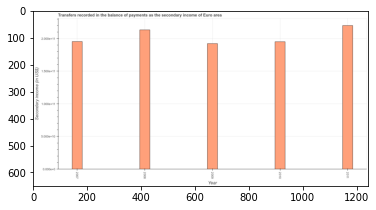

In [ ]:
img = mpimg.imread("/content/plotqa/TEST/png/"+str(IMAGE_ID)+".png")
imgplot = plt.imshow(img)

In [ ]:
# from google.colab import files
# # files.download("/content/plotqa/TEST/png/"+str(IMAGE_ID)+".png") 
# files.download("/content/STAGE-1/detections/32448.txt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

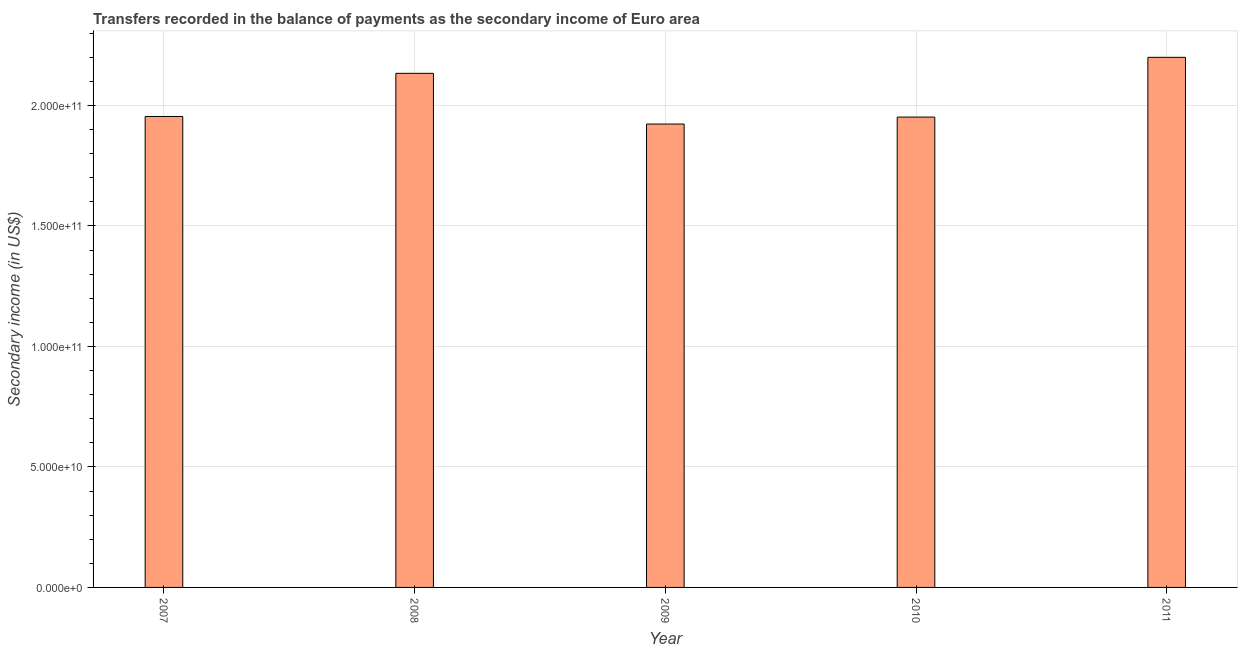

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Will use tool 'Tesseract (sh)'
100% 1/1 [00:02<00:00,  2.90s/it]
[Error Images]
[Empty Images]


In [ ]:
generate_csv(IMAGE_ID)

In [ ]:
df = pd.read_csv("/content/STAGE-1/final_csv/" + str(IMAGE_ID) + ".csv")
# df.drop(axis = 1 , labels = ['xlabel' , 'ylabel' ,'title'] , inplace= True)

In [ ]:
df

,Year,Secondary income (in US$),xlabel,ylabel,title
0,2009,1.948100,Year,Secondary income (in US$),ransfers recorded in the balance of payments a...
1,2008,2.156453,Year,Secondary income (in US$),ransfers recorded in the balance of payments a...
2,2010,1.970516,Year,Secondary income (in US$),ransfers recorded in the balance of payments a...
3,2011,2.219115,Year,Secondary income (in US$),ransfers recorded in the balance of payments a...
4,2007,1.976026,Year,Secondary income (in US$),ransfers recorded in the balance of payments a...


In [ ]:
%cd /content/

/content


In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/STAGE-1/final_csv/", "/content/final_csv")

['/content/final_csv/32448.csv']

In [ ]:
!rm /content/Miniconda3-4.5.12-Linux-x86_64.sh

In [ ]:
!rm -rf /content/content

In [ ]:
!rm -rf /content/STAGE-1

In [ ]:
!rm -rf /content/ocr_table_gen

In [ ]:
!cp "/content/final_csv" -r "/content/drive/MyDrive/Binary_Classifier"

# Load the binary classifier

In [ ]:
# Running Sequence
# Terminate Session
# Tapas -> Reset
# Load Classifier -> Reset
# Tapas -> No Reset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow
print(tensorflow.__version__) # 2.6.0

2.6.0


In [ ]:
!pip install tensorflow==2.6

  Using cached tensorflow-2.6.0-cp37-cp37m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl (4.0 MB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: h5py
    Found existing installation: h5p

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Binary_Classifier/binary_classifier.h5')

with open('/content/drive/MyDrive/Binary_Classifier/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [ ]:
def binary_classifier_predict(questions):
  maxlen = 100
  seq= loaded_tokenizer.texts_to_sequences(questions)
  padded = pad_sequences(seq, maxlen=maxlen)
  predictions = model.predict(padded)

  result = []
  for e in predictions:
    result.append(e[0])

  THRESHOLD = 0.5
  tapas_questions = []
  tabfact_questions = []
  for i in range(len(result)):
      # print("Question = ", questions[i])

      # Class 0
      if result[i] < THRESHOLD:
          # print("Class 0: Tabfact")
          tabfact_questions.append(questions[i])

      else:
          # print("Class 1: Tapas")
          tapas_questions.append(questions[i])

  return tapas_questions, tabfact_questions

In [ ]:
binary_classifier_predict(
    ['How many different coloured dotlines are there ?' ,
'Is the number of dotlines equal to the number of legend labels ?' ,
'What is the number of tourist arrivals in 1997 ?' ,
'Across all years, what is the maximum number of tourist arrivals ?' ,
'Across all years, what is the minimum number of tourist departures ?' ,
'In which year was the number of tourist arrivals maximum?' ,
'In which year was the number of tourist departures minimum?' ,
'What is the total number of tourist departures in the graph ?']
) # returns tapas_questions and tabfact_questions

(['How many different coloured dotlines are there ?',
  'What is the number of tourist arrivals in 1997 ?',
  'Across all years, what is the maximum number of tourist arrivals ?',
  'Across all years, what is the minimum number of tourist departures ?',
  'In which year was the number of tourist arrivals maximum?',
  'In which year was the number of tourist departures minimum?',
  'What is the total number of tourist departures in the graph ?'],
 ['Is the number of dotlines equal to the number of legend labels ?'])

# Download TAPAS

In [ ]:
! pip install tapas-table-parsing

  Using cached tensorflow-2.2.3-cp37-cp37m-manylinux2010_x86_64.whl (516.4 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h

In [ ]:
import tensorflow
print(tensorflow.__version__) 
# First = 2.2.3
# Then = 2.6.0

2.6.0


In [ ]:
! gsutil cp "gs://tapas_models/2020_10_07/tapas_wtq_wikisql_sqa_inter_masklm_large_reset.zip" "tapas_model.zip" && unzip tapas_model.zip
! mv tapas_wtq_wikisql_sqa_inter_masklm_large_reset tapas_model

Copying gs://tapas_models/2020_10_07/tapas_wtq_wikisql_sqa_inter_masklm_large_reset.zip...
| [1 files][  3.4 GiB/  3.4 GiB]   84.3 MiB/s                                   
Operation completed over 1 objects/3.4 GiB.                                      
Archive:  tapas_model.zip
   creating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/bert_config.json  
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/README.txt  
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/model.ckpt.index  
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/model.ckpt.data-00000-of-00001  
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/vocab.txt  
  inflating: tapas_wtq_wikisql_sqa_inter_masklm_large_reset/model.ckpt.meta  


# Download TABFACT

In [ ]:
! gsutil cp "gs://tapas_models/2020_10_07/tapas_tabfact_inter_masklm_large_reset.zip" "tabfact_model.zip" && unzip tabfact_model.zip
! mv tapas_tabfact_inter_masklm_large_reset tabfact_model

Copying gs://tapas_models/2020_10_07/tapas_tabfact_inter_masklm_large_reset.zip...
| [1 files][  3.4 GiB/  3.4 GiB]   51.7 MiB/s                                   
Operation completed over 1 objects/3.4 GiB.                                      
Archive:  tabfact_model.zip
   creating: tapas_tabfact_inter_masklm_large_reset/
  inflating: tapas_tabfact_inter_masklm_large_reset/bert_config.json  
  inflating: tapas_tabfact_inter_masklm_large_reset/README.txt  
  inflating: tapas_tabfact_inter_masklm_large_reset/model.ckpt.index  
  inflating: tapas_tabfact_inter_masklm_large_reset/model.ckpt.data-00000-of-00001  
  inflating: tapas_tabfact_inter_masklm_large_reset/vocab.txt  
  inflating: tapas_tabfact_inter_masklm_large_reset/model.ckpt.meta  


# Load TABFACT

In [ ]:


from google.colab import files
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import json
from natsort import natsorted 
import shutil
import pandas as pd
from statistics import median
from math import floor
from math import ceil

import numpy as np
import pickle
%matplotlib inline

import tensorflow.compat.v1 as tf
import os 
import shutil
import csv
import pandas as pd
import numpy as np
import IPython
print(tf.__version__)
tf.get_logger().setLevel('ERROR')



from tapas.utils import tf_example_utils
from tapas.protos import interaction_pb2
from tapas.utils import number_annotation_utils
import math




from tapas.utils import tf_example_utils
from tapas.protos import interaction_pb2
from tapas.utils import number_annotation_utils
from tapas.scripts import prediction_utils

2.6.0


In [ ]:
os.makedirs('results/tabfact/tf_examples', exist_ok=True)
os.makedirs('results/tabfact/model', exist_ok=True)
with open('results/tabfact/model/checkpoint', 'w') as f:
  f.write('model_checkpoint_path: "model.ckpt-0"')
for suffix in ['.data-00000-of-00001', '.index', '.meta']:
  shutil.copyfile(f'tabfact_model/model.ckpt{suffix}', f'results/tabfact/model/model.ckpt-0{suffix}')

In [ ]:
max_seq_length = 512
tabfact_vocab_file = "tabfact_model/vocab.txt"
tabfact_config = tf_example_utils.ClassifierConversionConfig(
    vocab_file=tabfact_vocab_file,
    max_seq_length=max_seq_length,
    max_column_id=max_seq_length,
    max_row_id=max_seq_length,
    strip_column_names=False,
    add_aggregation_candidates=False,
)
tabfact_converter = tf_example_utils.ToClassifierTensorflowExample(tabfact_config)

def tabfact_convert_interactions_to_examples(tables_and_queries):
  """Calls Tapas converter to convert interaction to example."""
  for idx, (table, queries) in enumerate(tables_and_queries):
    interaction = interaction_pb2.Interaction()
    for position, query in enumerate(queries):
      question = interaction.questions.add()
      question.original_text = query
      question.id = f"{idx}-0_{position}"
    for header in table[0]:
      interaction.table.columns.add().text = header
    for line in table[1:]:
      row = interaction.table.rows.add()
      for cell in line:
        row.cells.add().text = cell
    number_annotation_utils.add_numeric_values(interaction)
    for i in range(len(interaction.questions)):
      try:
        yield tabfact_converter.convert(interaction, i)
      except ValueError as e:
        print(f"Can't convert interaction: {interaction.id} error: {e}")
        
def tabfact_write_tf_example(filename, examples):
  with tf.io.TFRecordWriter(filename) as writer:
    for example in examples:
      writer.write(example.SerializeToString())

def tabfact_predict_new(table_data, queries):
  table = table_data
  examples = tabfact_convert_interactions_to_examples([(table, queries)])
  tabfact_write_tf_example("results/tabfact/tf_examples/test.tfrecord", examples)
  tabfact_write_tf_example("results/tabfact/tf_examples/dev.tfrecord", [])
  
  ! python -m tapas.run_task_main \
    --task="TABFACT" \
    --output_dir="results" \
    --noloop_predict \
    --test_batch_size={len(queries)} \
    --tapas_verbosity="ERROR" \
    --compression_type= \
    --reset_position_index_per_cell \
    --init_checkpoint="tabfact_model/model.ckpt" \
    --bert_config_file="tabfact_model/bert_config.json" \
    --mode="predict" 2> error


  results_path = "results/tabfact/model/test.tsv"
  all_results = []
  df = pd.DataFrame(table[1:], columns=table[0])
  # display(IPython.display.HTML(df.to_html(index=False)))
  print()
  with open(results_path) as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for row in reader:
      supported = int(row["pred_cls"])
      all_results.append(supported)
      score = float(row["logits_cls"])
      position = int(row['position'])
      print(queries[position])
      if supported:
        print("> YES")
      else:
        print("> NO")
  print()
  return all_results

# Load TAPAS

In [ ]:
os.makedirs('results/wtq/tf_examples', exist_ok=True)
os.makedirs('results/wtq/model', exist_ok=True)
with open('results/wtq/model/checkpoint', 'w') as f:
  f.write('model_checkpoint_path: "model.ckpt-0"')
for suffix in ['.data-00000-of-00001', '.index', '.meta']:
  shutil.copyfile(f'tapas_model/model.ckpt{suffix}', f'results/wtq/model/model.ckpt-0{suffix}')

In [ ]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [ ]:
def Average(Values) :  
  res_avg = sum(float(x) for x in Values if x != 'nan') / len(Values)
  return str(res_avg)
  # res_average = np.mean(Values)
  # return str(res_average)

def Count(Values) :
  return str(len(Values))

def Sum(Values):
  if isfloat(Values[0]):
    return str(sum(float(x) for x in Values if x != 'nan'))
  else:
    return str("")
  # return str(np.sum(Values))

def Max(Values):
  pass

def Min(Values):
  pass

In [ ]:
def predict_new(table_data, queries, display = False):

  table = table_data
  examples = convert_interactions_to_examples([(table, queries)])
  write_tf_example("results/wtq/tf_examples/test.tfrecord", examples)
  write_tf_example("results/wtq/tf_examples/random-split-1-dev.tfrecord", [])
  
  ! python -m tapas.run_task_main \
    --task="WTQ" \
    --output_dir="results" \
    --noloop_predict \
    --test_batch_size={len(queries)} \
    --tapas_verbosity="ERROR" \
    --compression_type= \
    --reset_position_index_per_cell \
    --init_checkpoint="tapas_model/model.ckpt" \
    --bert_config_file="tapas_model/bert_config.json" \
    --mode="predict" 2> error

  ANSWERS = []
  results_path = "results/wtq/model/test.tsv"
  all_coordinates = []
  df = pd.DataFrame(table[1:], columns=table[0])
  print("\n\n\n")
  # display(IPython.display.HTML(df.to_html(index=False)))
  Method_mapper = {'AVERAGE' : Average , 'SUM' : Sum , 'COUNT' : Count , 'MAX' : Max , 'MIN' : Min}
  print()
  with open(results_path) as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    query_index = 0

    for row in reader:
      coordinates = sorted(prediction_utils.parse_coordinates(row["answer_coordinates"]))
      all_coordinates.append(coordinates)
      answers = ', '.join([table[row + 1][col] for row, col in coordinates])
      position = int(row['position'])
      aggregation = aggregation_to_string(int(row["pred_aggr"]))

      if display:
        print(">", queries[position])
      answer_text = str(answers)
      #print(aggregation ,  type(aggregation)  , answers , type(answers) , answer_text , type(answer_text) , sep = "\n")
      # print(aggregation, answer_text)

      if re.search("list", queries[position]):
          answer_text += "\n"
          ANSWERS.append(answer_text)

      elif aggregation != "NONE":
        num_results = answer_text.split(",")
        num_results = [num.strip() for num in num_results]

        num_results = [float(x) if x.isnumeric() else x for x in num_results]
        
        #print("NUMS : " , num_results)

        answer_text = f"{aggregation} of {answer_text}"

        actual_answer = Method_mapper[aggregation](num_results)

        answer_text = answer_text + "\n" + actual_answer + "\n"
        ANSWERS.append(actual_answer)
    
      else:
          answer_text += "\n"
          ANSWERS.append(answer_text)
    
      if display:
        print(answer_text)

        # print("EXPECTED = ", plotqa_data[queries[position]])
        # print("PREDICTED = ", answer_text)

        print("\n")

  return ANSWERS

In [ ]:
max_seq_length = 512
vocab_file = "tapas_model/vocab.txt"
config = tf_example_utils.ClassifierConversionConfig(
    vocab_file=vocab_file,
    max_seq_length=max_seq_length,
    max_column_id=max_seq_length,
    max_row_id=max_seq_length,
    strip_column_names=False,
    add_aggregation_candidates=False,
)
converter = tf_example_utils.ToClassifierTensorflowExample(config)


def convert_interactions_to_examples(tables_and_queries):
  """Calls Tapas converter to convert interaction to example."""
  for idx, (table, queries) in enumerate(tables_and_queries):
    interaction = interaction_pb2.Interaction()
    for position, query in enumerate(queries):
      question = interaction.questions.add()
      question.original_text = query
      question.id = f"{idx}-0_{position}"
    for header in table[0]:
      interaction.table.columns.add().text = header
    for line in table[1:]:
      row = interaction.table.rows.add()
      for cell in line:
        row.cells.add().text = cell
    number_annotation_utils.add_numeric_values(interaction)
    for i in range(len(interaction.questions)):
      try:
        yield converter.convert(interaction, i)
      except ValueError as e:
        print(f"Can't convert interaction: {interaction.id} error: {e}")
        
def write_tf_example(filename, examples):
  with tf.io.TFRecordWriter(filename) as writer:
    for example in examples:
      writer.write(example.SerializeToString())

def aggregation_to_string(index):
  if index == 0:
    return "NONE"
  if index == 1:
    return "SUM"
  if index == 2:
    return "AVERAGE"
  if index == 3:
    return "COUNT"
  raise ValueError(f"Unknown index: {index}")

# Load Functions used in TAPAS

In [ ]:
def get_csvfile_path(ind):
  return "/content/plotqa/TEST/csv/FrRCNN_test_predicted_tables_0.5/"+str(annot[ind]["image_index"])+".csv"

In [ ]:
def get_list_of_list(path, display = False):
    df = pd.read_csv(path)
    df = df.astype(str)
    # df.drop(axis = 1 , labels = ['Unknown' , 'xlabel' , 'ylabel' ,'title' , 'legend orientation'] , inplace= True)
    df = df.sort_values(df.columns[0],ignore_index=True)
    if display:
        print(df)

    list_of_list_1 = [[]]
    list_of_list_1[0] = list(df.columns)
    list_of_list_1.extend(df.values.tolist()) 
    return list_of_list_1

In [ ]:
def display_image_qa_pairs(img_id):

  print("png/"+str(img_id)+".png")
  for i, path in enumerate(images):
    if re.search("png/"+str(img_id)+".png", path):
      break

  # Image
  print("\nImage:\n")
  print(images[i])
  img = mpimg.imread(images[i])
  imgplot = plt.imshow(img)
  plt.show()

  questions = list()
  answers = list()
  print("\nQA Pairs:\n")
  img_index = annot[i]["image_index"]
  count = 0

  for j in qa["qa_pairs"]:
    if j["image_index"] == img_index:
      count  += 1
 
      print(f"Q{count}: {j['question_string']}")
      print(f"Ans: {j['answer']}")
      questions.append(j['question_string'])
      answers.append(j['answer'])

  return i, questions, answers


# # global variable theirs
# def get_comparison(theirs, ours, questions, answers):
#   d = dict()
#   for ques, ans in theirs:
#     d[ques] = ans

#   for ques, ans in ours:
#     d[ques] = ans

#   for i in range(len(questions)):
#     print(questions[i])
#     print("EXPECTED: " + str(answers[i]))
#     print("GOT: " + str(d[questions[i]]))


In [ ]:
def spilt_ratio(query):
    s1 = []
    s2 = []
    flag = False
    query = query.split()
    i = 0
    while i < len(query):
        if query[i] != "to":
            s1.append(query[i])
            i = i + 1
        elif i+1 < len(query):
            s2 = s1[:-1]
            s2.append(query[i+1])
            flag = True
            i = i + 2
        while flag and i < len(query):
            s1.append(query[i])
            s2.append(query[i])
            i += 1
    return " ".join(s1), " ".join(s2)

# works - "What is the ratio of male workers in 1981 to 1980 for the country Hong Kong"
# doesn't work - What is the ratio of the education completion rate of male students in Burkina Faso to that in Cabo Verde ?

In [ ]:
def find_ratio(q, list_of_list):
    q = re.sub("ratio", "", q , flags = re.I)
    q1, q2 = spilt_ratio(q)
    res = predict_new(list_of_list, [q1, q2])

    return str(float(res[0]) / float(res[1]))

In [ ]:
def find_trend(q, list_of_list):
    def is_increasing(vals):
        return all(i <= j for i, j in zip(vals, vals[1:]))

    def is_decreasing(vals):
        return all(i >= j for i, j in zip(vals, vals[1:]))


    query = "get the list of all values" + q[re.search("trend", q, flags = re.I).end():]
    list_val = predict_new(list_of_list, [query]) 
    vals = list(map(lambda val: float(val), list_val[0].split(", ")))

    if is_increasing(vals):
        return "INCREASING"
    elif is_decreasing(vals):
        return "DECREASING"
    else:
        return "NONE"

In [ ]:
def find_median(q, list_of_list, columns):
    for col in columns:
        if re.search(col, q):
            query = "get the list of all values in " + col
            list_val = predict_new(list_of_list, [query])
            vals = list(map(lambda val: float(val), list_val[0].split(", ")))
            return median(vals)

In [ ]:
def find_difference(q, list_of_list, column):
    q = "".join(q.split("difference between")[-1]).strip()
    pat = re.compile(r'\band\b')
    x = pat.search(q) 
    if x != None:
      q1 = q[0: x.span()[0]]
      name2 = q[x.span()[1] :] 
      qsplit = q1.split()
      q2 = qsplit[:-1]
      q2 = ' '.join(q2) + name2
      # print(q1)
      # print(q2)
      val1, val2 = predict_new(list_of_list, [q1, q2]) 
        
      return str(abs(float(val1) - float(val2)))


In [ ]:
def find_range(q, list_of_list):
  subquery = q.split("range")[-1].strip()
  q1 = "maximum " + subquery
  q2 = "minimum " + subquery
  maximum, minimum = predict_new(list_of_list, [q1, q2])
  return str(float(maximum) - float(minimum))

In [ ]:
def find_quartiles(q, list_of_list, columns):
  for col in columns:
    if re.search(col, q):
      query = "get the list of all values in " + col
      list_val = predict_new(list_of_list, [query])
      vals = list(map(lambda val: float(val), list_val[0].split(", ")))
      vals.sort()
      n = len(vals)

      q1 = (n + 1)/4
      q3 = 3*(n + 1)/4
      # print(n, q1, q3)
      if (n + 1) % 4:
        q1_left = floor(q1)
        q1_right = ceil(q1)
        q1_value = ( vals[q1_left-1] + vals[q1_right-1] ) / 2

      else:
        q1_value = vals[q1-1]


      if (3*(n + 1)) % 4:
        q3_left = floor(q3)
        q3_right = ceil(q3)
        q3_value = ( vals[q3_left-1] + vals[q3_right-1] ) / 2
      else:
        q3_value = vals[q3-1]

      q2_value = median(vals)

      return str(q1_value), str(q2_value), str(q3_value)

In [ ]:
def find_iqr(q1, q3):
  return str(float(q3) - float(q1))

In [ ]:
def tapas_find_answers(question, columns, list_of_list):

  
    unanswered = []
    for qes in question:
        qes = qes.lower()
        if re.search("x-axis", qes):
            ans = data[-1][data[0].index("xlabel")]
            print(">", qes)
            print("X-LABEL = ", ans)
            print("\n")

        elif re.search("y-axis", qes):
            ans = data[-1][data[0].index("ylabel")]
            print(">", qes)
            print("Y-LABEL = ", ans)
            print("\n")

        elif re.search("title", qes):
            ans = data[-1][data[0].index("title")]
            print(">", qes)
            print("TITLE OF THE GRAPH = ", ans)
            print("\n")

        elif re.search("ratio", qes):
            ans = find_ratio(qes, list_of_list)
            print(">", qes)
            print("RATIO = ", ans)
            print("\n")

        elif re.search("median", qes):
            ans = find_median(qes, list_of_list, columns)
            print(">", qes)
            print("MEDIAN = ", ans)
            print("\n")

        elif re.search("trend", qes):
            ans = find_trend(qes, list_of_list)
            print(">", qes)
            print("TREND = ", ans)
            print("\n")

        elif re.search("difference", qes):
            ans = find_difference(qes, list_of_list, columns)
            print(">", qes)
            print("DIFFERENCE = ", ans)
            print("\n")

        elif re.search("interquartile range", qes):
            q1, _, q3 = find_quartiles(qes, list_of_list, columns)
            ans = find_iqr(q1, q3)
            print(">", qes)
            print("INTER-QUARTILE RANGE = ", ans)
            print("\n")

        elif re.search("quartiles", qes):
            q1, q2, q3 = find_quartiles(qes, list_of_list, columns)
            print(">", qes)
            print("FIRST QUARTILE (Q1) = ", q1)
            print("SECOND QUARTILE (Q2) = ", q2)
            print("THIRD QUARTILE (Q3) = ", q3)
            print("\n")

            
        elif re.search("range", qes):
            ans = find_range(qes, list_of_list)
            print(">", qes)
            print("RANGE = ", ans)
            print("\n")

        else:
            unanswered.append(qes)
    if unanswered:
        res = predict_new(list_of_list, unanswered, True) 

In [ ]:
# def tapas_find_answers(question, columns, list_of_list):

  
#     unanswered = []
#     for qes in question:
#         qes = qes.lower()
#         if re.search("ratio", qes):
#             ans = find_ratio(qes, list_of_list)
#             print(">", qes)
#             print("RATIO = ", ans)
#             print("\n")

#         elif re.search("median", qes):
#             ans = find_median(qes, list_of_list, columns)
#             print(">", qes)
#             print("MEDIAN = ", ans)
#             print("\n")

#         elif re.search("trend", qes):
#             ans = find_trend(qes, list_of_list)
#             print(">", qes)
#             print("TREND = ", ans)
#             print("\n")

#         elif re.search("difference", qes):
#             ans = find_difference(qes, list_of_list, columns)
#             print(">", qes)
#             print("DIFFERENCE = ", ans)
#             print("\n")

#         elif re.search("interquartile range", qes):
#             q1, _, q3 = find_quartiles(qes, list_of_list, columns)
#             ans = find_iqr(q1, q3)
#             print(">", qes)
#             print("INTER-QUARTILE RANGE = ", ans)
#             print("\n")

#         elif re.search("quartiles", qes):
#             q1, q2, q3 = find_quartiles(qes, list_of_list, columns)
#             print(">", qes)
#             print("FIRST QUARTILE (Q1) = ", q1)
#             print("SECOND QUARTILE (Q2) = ", q2)
#             print("THIRD QUARTILE (Q3) = ", q3)
#             print("\n")

            
#         elif re.search("range", qes):
#             ans = find_range(qes, list_of_list)
#             print(">", qes)
#             print("RANGE = ", ans)
#             print("\n")

#         else:
#             unanswered.append(qes)
#     if unanswered:
#         res = predict_new(list_of_list, unanswered, True) 

# Load Functions used in TABFACT

In [ ]:
def part_answer(parts, columns, list_of_list):
  to_return = []
  for part in parts:
    if re.search("ratio", part, flags = re.I):
        ans = find_ratio(part, list_of_list)
        print(">", part)
        print("RATIO = ", ans)
        print("\n")
        to_return.append(ans)

    elif re.search("median", part, flags = re.I):
        ans = find_median(part, list_of_list, columns)
        print(">", part)
        print("MEDIAN = ", ans)
        print("\n")
        to_return.append(ans)

    elif re.search("sum", part, flags = re.I):
        ans = predict_new(list_of_list, [part])
        print(">", part)
        print("ANS FROM TAPAS = ", ans[0])
        print("\n")
        to_return.append(ans[0])

    elif re.search("difference", part, flags = re.I):
        ans = find_difference(part, list_of_list, columns)
        print(">", part)
        print("DIFFERENCE = ", ans)
        print("\n")
        to_return.append(ans)

    elif re.search("trend", part, flags = re.I):
        ans = find_trend(part, list_of_list)
        print(">", part)
        print("TREND = ", ans)
        print("\n")
        to_return.append(ans)

    else:
        ans = predict_new(list_of_list, [part])
        print(">", part)
        print("ANS FROM TAPAS = ", ans[0])
        print("\n")
        to_return.append(ans[0])
        # return "NOT_FOUND"
  return to_return        

def tabfact_find_answers(list_of_list, question, columns):
    unanswered = []
    pattern = re.compile(r'\bgreat\b|\bgreater\b|\bhigh\b|\bhigher\b|\blow\b|\blower\b|\bless\b|\blesser\b|\bsmall\b|\bsmaller\b|\bequal\b', flags=re.I | re.X)
    prelim = re.compile(r'\bratio\b|\bmedian\b|\bdifference\b|\bsum\b', flags=re.I | re.X)
    incdec = re.compile(r'\bincrease\b|\bincreasing\b|\bdecrease\b|\bdecreasing\b', flags=re.I | re.X)
    for qes in question:
        qes = qes.lower()
        if prelim.search(qes) != None:
          x = pattern.search(qes)
          if x != None:
            try:
              first_part = qes[0: x.span()[0]]
              second_part = qes[x.span()[1] : ] 

              # print("FIRST PART :", first_part)
              # print("SECOND PART:", second_part)

              first_ans , second_ans = part_answer([first_part, second_part],  columns, list_of_list)
              # second_ans = part_answer(second_part, columns, list_of_list) 

              
              exact_match = x.group().lower()
              fl_fans = round(float(first_ans), 2)
              fl_sans = round(float(second_ans), 2)

              if exact_match == "equal":
                if fl_fans == fl_sans:
                    print("> SUPPORTS:", qes)
                else:
                  print("> REFUTES", qes)

              elif exact_match == "great" or exact_match == "greater" or exact_match == "high" or exact_match == "higher":
                if fl_fans > fl_sans:
                  print("> SUPPORTS:", qes)
                else:
                  print("> REFUTES", qes)

              else:
                if fl_fans < fl_sans:
                  print("> SUPPORTS:", qes)
                else:
                  print("> REFUTES", qes)

            except:
              unanswered.append(qes)
          else:
            unanswered.append(qes) 
        else:
          unanswered.append(qes)
          # find_incdec  = incdec.search(qes)
          # if find_incdec != None:
          #   get_trend_for_qes = qes[0: find_incdec.span()[0]]
          #   final_qes = ' '.join(get_trend_for_qes.split()[:-1])
          #   final_qes = "get trend for " + final_qes
          #   got_ans = part_answer([final_qes],  columns, list_of_list)
          #   ans = got_ans[0]

          #   exact_match = find_incdec.group().lower()

          #   if exact_match in ["increase", "increasing"]:
          #     if ans == "INCREASING":
          #        print("> SUPPORTS:", qes)
          #     else:
          #        print("> REFUTES", qes)
          #   elif exact_match in ["decrease", "decreasing"]:
          #     if ans == "DECREASING":
          #       print("> SUPPORTS:", qes)
          #     else:
          #       print("> REFUTES", qes)
          #   else:
          #     print("> REFUTES", qes)
          
          # else:
          #   unanswered.append(qes)


    if unanswered:
        res = tabfact_predict_new(list_of_list, unanswered) 

In [ ]:
!rm /content/tabfact_model.zip

In [ ]:
!rm /content/tapas_model.zip

# Load Images and Annotations

In [ ]:
!mkdir "plotqa"

# Images

# https://drive.google.com/file/d/1MpqaHqqPRGjRht9w672DJbxMwZx1j3qC/view?usp=sharing
!gdown -O "TEST.tar.gz" --id 1MpqaHqqPRGjRht9w672DJbxMwZx1j3qC

!tar -xvf  '/content/TEST.tar.gz' -C '/content/plotqa/'

!rm TEST.tar.gz

Streaming output truncated to the last 5000 lines.
TEST/png/9525.png
TEST/png/27535.png
TEST/png/2324.png
TEST/png/24199.png
TEST/png/5976.png
TEST/png/21791.png
TEST/png/28934.png
TEST/png/17043.png
TEST/png/4326.png
TEST/png/21901.png
TEST/png/18113.png
TEST/png/27814.png
TEST/png/20542.png
TEST/png/10557.png
TEST/png/14240.png
TEST/png/9661.png
TEST/png/22899.png
TEST/png/20728.png
TEST/png/16651.png
TEST/png/6325.png
TEST/png/24477.png
TEST/png/30715.png
TEST/png/23348.png
TEST/png/14643.png
TEST/png/17510.png
TEST/png/3392.png
TEST/png/23341.png
TEST/png/1946.png
TEST/png/32301.png
TEST/png/10984.png
TEST/png/2385.png
TEST/png/30516.png
TEST/png/13308.png
TEST/png/17750.png
TEST/png/28523.png
TEST/png/8054.png
TEST/png/25213.png
TEST/png/28977.png
TEST/png/29057.png
TEST/png/12706.png
TEST/png/12463.png
TEST/png/791.png
TEST/png/5352.png
TEST/png/20372.png
TEST/png/1647.png
TEST/png/19889.png
TEST/png/7593.png
TEST/png/24825.png
TEST/png/29991.png
TEST/png/789.png
TEST/png/13106.p

In [ ]:
from google.colab import files
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import json
from natsort import natsorted 
import shutil
import pandas as pd
from statistics import median
from math import floor
from math import ceil
from distutils.dir_util import copy_tree

import numpy as np
import pickle
%matplotlib inline

In [ ]:
images = natsorted(glob.glob("/content/plotqa/TEST/png/*png"))
print(f"Number of Images in Testing set = {len(images)}")

Number of Images in Testing set = 33657


In [ ]:
with open('/content/plotqa/TEST/annotations.json') as f:
  annot = json.load(f)

print(type(annot))   # List of dict 
print(len(annot))
annot = sorted(annot, key=lambda k: k['image_index']) 

<class 'list'>
33657


In [ ]:
with open('/content/plotqa/TEST/qa_pairs.json') as fp:
    qa = json.load(fp)
print(len(qa["qa_pairs"]))
print(qa["qa_pairs"][0])

1228313
{'image_index': 0, 'qid': 'S7', 'question_string': 'How many different coloured dotlines are there ?', 'answer_bbox': [], 'template': 'structural', 'answer': 2, 'answer_id': 0, 'type': 'dot', 'question_id': 0}


In [ ]:
%mkdir final_csv

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/drive/MyDrive/Binary_Classifier/final_csv", "/content/final_csv")

['/content/final_csv/32448.csv']

In [ ]:
csvs = natsorted(glob.glob("/content/final_csv/*csv"))

In [ ]:
csvs

['/content/final_csv/32448.csv']

In [ ]:
plot_types = dict()
for item in annot:
  if item["type"] not in plot_types:
    plot_types[item["type"]] = [item["image_index"]]
  else:
    plot_types[item["type"]].append(item["image_index"])

In [ ]:
for k in plot_types:
    print(f"{k} = {len(plot_types[k])}")

dot_line = 5574
hbar_categorical = 11292
line = 5549
vbar_categorical = 11242


# QA - User Input Questions

In [ ]:
w = csvs[0].split("final_csv/")[-1]
IMAGE_ID = w.split(".csv")[0]
print(IMAGE_ID)

32448


png/32448.png

Image:

/content/plotqa/TEST/png/32448.png


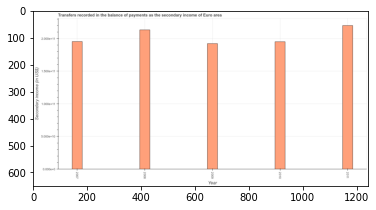


QA Pairs:

Q1: Does the graph contain any zero values ?
Ans: No
Q2: Does the graph contain grids ?
Ans: Yes
Q3: What is the title of the graph ?
Ans: Transfers recorded in the balance of payments as the secondary income of Euro area
Q4: What is the label or title of the X-axis ?
Ans: Year
Q5: What is the label or title of the Y-axis ?
Ans: Secondary income (in US$)
Q6: What is the amount of secondary income in 2010 ?
Ans: 195176403347.6
Q7: Across all years, what is the maximum amount of secondary income ?
Ans: 219970044252.4
Q8: Across all years, what is the minimum amount of secondary income ?
Ans: 192289140697.7
Q9: In which year was the amount of secondary income maximum ?
Ans: 2011
Q10: In which year was the amount of secondary income minimum ?
Ans: 2009
Q11: What is the sum of the amount of secondary income ?
Ans: 1016190386269.5
Q12: What is the difference between the amount of secondary income in 2008 and 2010 ?
Ans: 18151018443.2
Q13: What is the average amount of secondary i

In [ ]:
ind, plotqa_questions, plotqa_answers = display_image_qa_pairs(IMAGE_ID)

In [ ]:
df = pd.read_csv(csvs[0])
df.drop(axis = 1 , labels = [ 'xlabel' , 'ylabel' ,'title' ] , inplace= True)
columns = list(df.columns)

data = get_list_of_list(csvs[0], True)

   Year  ...                                              title
0  2007  ...  ransfers recorded in the balance of payments a...
1  2008  ...  ransfers recorded in the balance of payments a...
2  2009  ...  ransfers recorded in the balance of payments a...
3  2010  ...  ransfers recorded in the balance of payments a...
4  2011  ...  ransfers recorded in the balance of payments a...

[5 rows x 5 columns]


In [ ]:
df = df.sort_values("Year", ignore_index=True)
df

,Year,Secondary income (in US$)
0,2007,1.976026
1,2008,2.156453
2,2009,1.948100
3,2010,1.970516
4,2011,2.219115


In [ ]:
questions =  [
            "what are the total number of years",
            "what are the names all the years",
            'Across all Secondary incomes, what is the maximum transfers of payments ?',
            "which year has the maximum Secondary income",
            "what is the total Secondary income for years 2008, 2011",
            "what is the Secondary income for the year 2010",
            "what is the average Secondary income",
            "What is the trend for the year 2009, 2010, 2011 for Secondary income",
            "what is the maximum transfer of payments for the Secondary income",
            "what is the minimum transfer of payments for the Secondary income",
            "what is the range of transfer of payments for the Secondary income"
            "What is the title of the graph ?",
            "What is the label or title of the X-axis ?",
            "What is the label or title of the Y-axis ?"
]

In [ ]:
tapas_questions, tabfact_questions = binary_classifier_predict(questions)

In [ ]:
# tapas_find_answers_TEST(tapas_questions, columns, data, plotqa_data)
tapas_find_answers(tapas_questions, columns, data)

is_built_with_cuda: True
is_gpu_available: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training or predicting ...
Evaluation finished after training step 0.





> what is the trend for the year 2009, 2010, 2011 for secondary income
TREND =  INCREASING


> what is the range of transfer of payments for the secondary incomewhat is the title of the graph ?
TITLE OF THE GRAPH =  ransfers recorded in the balance of payments as the secondary income of Euro area


> what is the label or title of the x-axis ?
X-LABEL =  Year


> what is the label or title of the y-axis ?
Y-LABEL =  Secondary income (in US$)


is_built_with_cuda: True
is_gpu_available: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training or predicting ...
Evaluation finished after training step 0.





> what are the total number of years
COUNT of 2007, 2008, 2009, 2010, 2011
5



> what are the names all the years
2007, 2008, 2009, 2010, 2011



> across all s

In [ ]:
# list_of_list, columns = get_table(images, IMAGE_ID)
tabfact_find_answers(data, tabfact_questions, columns) 

is_built_with_cuda: True
is_gpu_available: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training or predicting ...
Evaluation finished after training step 0.

in the country pakistan, 2007 has the highest expenditure
> YES



--------- END ---------